<a id='1.3'></a>
## 2.3. Import Packages

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config import config
from finrl.marketdata.yahoodownloader import YahooDownloader
from finrl.preprocessing.preprocessors import FeatureEngineer
from finrl.preprocessing.data import data_split
from finrl.env.env_stocktrading import StockTradingEnv
from finrl.model.models import DRLAgent,DRLEnsembleAgent
from finrl.trade.backtest import get_baseline, backtest_stats, backtest_plot

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

from pyfolio import timeseries
import pyfolio
import matplotlib.dates as mdates
from copy import deepcopy

import pickle
import dill
import time

In [3]:
rebalance_window = 63 # rebalance_window is the number of days to retrain the model
validation_window = 63 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)
train_start = '2004-08-11'
train_end = '2016-01-01'
val_test_start = '2016-01-01'
val_test_end = '2021-06-11'

In [4]:
dill.load_session('17_year_sharpe_reward_dow.db')

In [5]:
def backtest_plot(
    account_value,
    baseline_start=config.START_TRADE_DATE,
    baseline_end=config.END_DATE,
    baseline_ticker="^DJI",
    value_col_name="account_value",
):

    df = deepcopy(account_value)
    test_returns = get_daily_return(df, value_col_name=value_col_name)

    baseline_df = get_baseline(
        ticker=baseline_ticker, start=baseline_start, end=baseline_end
    )

    baseline_returns = get_daily_return(baseline_df, value_col_name="close")
    with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(
            returns=test_returns, benchmark_rets=baseline_returns, set_context=False
        )
def get_daily_return(df, value_col_name="account_value"):
    df = deepcopy(df)
    df["daily_return"] = df[value_col_name].pct_change(1)
    df["date"] = pd.to_datetime(df["date"])
    df.set_index("date", inplace=True, drop=True)
    df.index = df.index.tz_localize("UTC")
    return pd.Series(df["daily_return"], index=df.index)

<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [6]:

with open('17_year_more_models_dow_processed_full.pkl', 'rb') as f:
    processed_full = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: '17_year_more_models_dow_processed_full.pkl'

In [7]:
unique_trade_date = processed_full[(processed_full.date > val_test_start)&(processed_full.date <= val_test_end)].date.unique()

In [8]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

df_account_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i))
    df_account_value = df_account_value.append(temp,ignore_index=True)
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))

Sharpe Ratio:  0.4611006518986191


In [9]:
df_account_value.head()

,account_value,date,daily_return,datadate
0,500000.000000,2016-04-05,NaN,2016-04-05
1,500365.802731,2016-04-06,0.000732,2016-04-06
2,498249.119875,2016-04-07,-0.004230,2016-04-07
3,498104.408400,2016-04-08,-0.000290,2016-04-08
4,497600.826171,2016-04-11,-0.001011,2016-04-11


<AxesSubplot:>

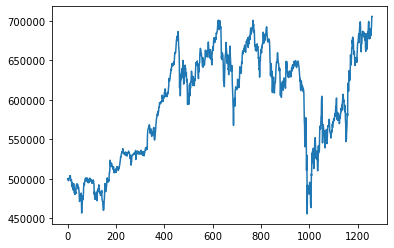

In [10]:
%matplotlib inline
df_account_value.account_value.plot()

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [11]:
%load_ext autoreload
%autoreload 2

In [12]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
Annual return          0.071281
Cumulative returns     0.410965
Annual volatility      0.187690
Sharpe ratio           0.461101
Calmar ratio           0.203768
Stability              0.338557
Max drawdown          -0.349813
Omega ratio            1.093115
Sortino ratio          0.652193
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.953709
Daily value at risk   -0.023303
dtype: float64


In [13]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1259, 8)
Annual return          0.137640
Cumulative returns     0.904595
Annual volatility      0.200029
Sharpe ratio           0.746062
Calmar ratio           0.371136
Stability              0.799441
Max drawdown          -0.370862
Omega ratio            1.179035
Sortino ratio          1.028178
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.883798
Daily value at risk   -0.024609
dtype: float64


<a id='6.2'></a>
## 7.2 BackTestPlot

==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1259, 8)


Start date,2016-04-05
End date,2021-04-05
Total months,59
,Backtest
Annual return,7.145%
Cumulative returns,41.169%
Annual volatility,18.776%
Sharpe ratio,0.46
Calmar ratio,0.20
Stability,0.34
Max drawdown,-34.981%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,34.98,2018-09-24,2020-03-12,2021-04-05,661
1,13.46,2018-01-26,2018-03-23,2018-09-18,168
2,9.38,2016-04-20,2016-06-27,2016-12-07,166
3,3.89,2017-03-01,2017-04-19,2017-07-14,98
4,3.40,2017-08-07,2017-09-06,2017-09-15,30


Stress Events,mean,min,max
New Normal,0.03%,-9.24%,9.20%


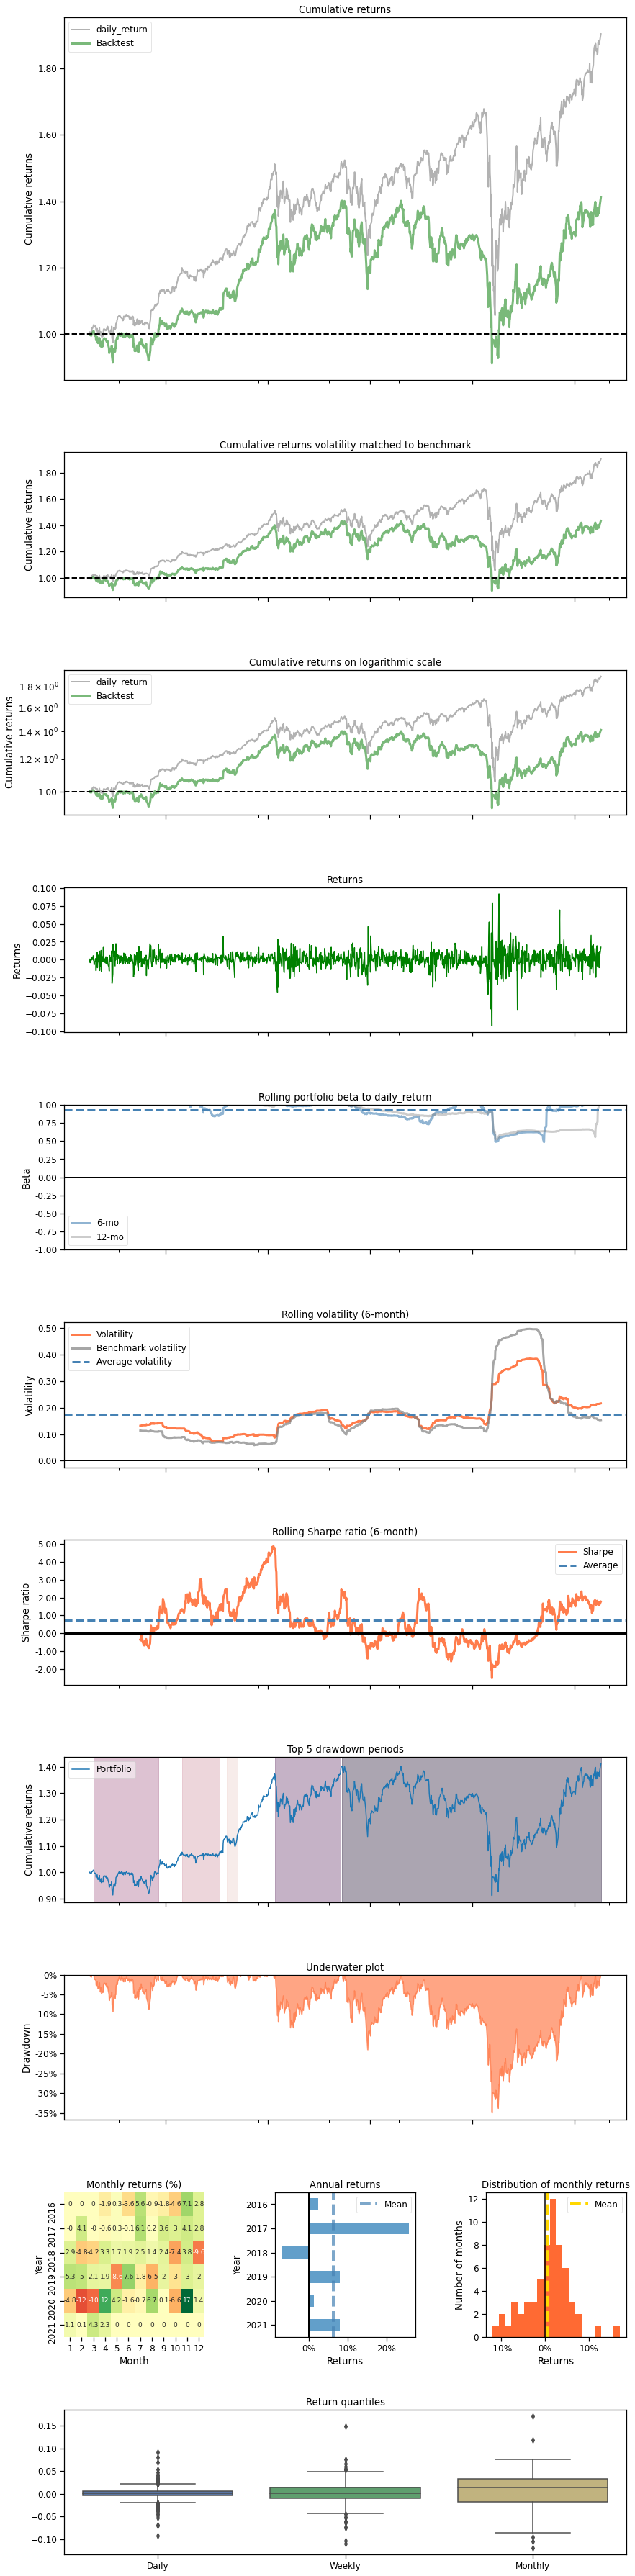

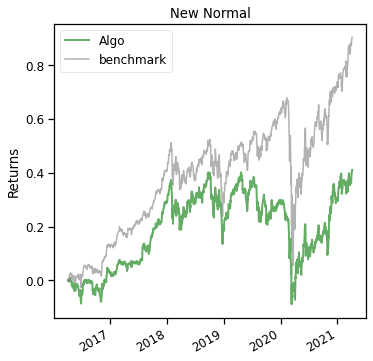

In [14]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value.loc[0,'date'],
             baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])

In [15]:
print("==============Get Baseline Stats===========")
baseline_perf_stats=get_baseline('^DJI',
                                  start = df_account_value.loc[0,'date'],
                                  end = df_account_value.loc[len(df_account_value)-1,'date'])
print(baseline_perf_stats)

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1259, 8)
            date          open          high           low         close  \
0     2016-04-05  17718.029297  17718.029297  17579.560547  17603.320312   
1     2016-04-06  17605.449219  17723.550781  17542.539062  17716.050781   
2     2016-04-07  17687.279297  17687.279297  17484.230469  17541.960938   
3     2016-04-08  17555.390625  17694.509766  17528.160156  17576.960938   
4     2016-04-11  17586.480469  17731.630859  17555.900391  17556.410156   
...          ...           ...           ...           ...           ...   
1254  2021-03-29  33087.550781  33259.000000  32905.128906  33171.371094   
1255  2021-03-30  33127.878906  33170.929688  32988.921875  33066.960938   
1256  2021-03-31  33116.039062  33173.769531  32980.570312  32981.550781   
1257  2021-04-01  33054.578125  33167.171875  32985.351562  33153.210938   
1258  2021-04-05  33

<a id='6.3'></a>
## 7.3 Baseline Stats